In [1]:
!conda activate deepCB

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time
import pandas as pd

import copy
import os
import pickle

import numpy as np
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

# libact classes
from libact.base.dataset import Dataset, DatasetBiome, import_libsvm_sparse
from libact.models import SVM
from libact.query_strategies import RepresentativeSampling, UncertaintySampling, RandomSampling,\
    ActiveLearningByLearning, ContextualBanditsActiveLearning, MultiBanditsActiveLearning, UniformBanditsActiveLearning
from libact.labelers import IdealLabeler

import tensorflow as tf
from libact.query_strategies.bandits.algorithms.uniform_sampling import UniformSampling
from libact.query_strategies.bandits.algorithms.linear_full_posterior_sampling import LinearFullPosteriorSampling

class NetBiome(nn.Module):
    def __init__(self):
        super(NetBiome, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=6, stride=3)
        self.convdropout1 = nn.Dropout2d()
        self.conv2 = nn.Conv2d(96, 64, kernel_size=3, stride=2)
        self.convdropout2 = nn.Dropout2d()
        self.fc1 = nn.Linear(576, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.convdropout1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.convdropout2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 576)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        out = F.log_softmax(x, dim=1)
        
        return out, e1

    def get_embedding_dim(self):
        return 128

def split_train_test_Biome(X_raw, y_raw , test_size, n_labeled, args):
    X, y = X_raw, y_raw
    splt_id = int(len(X) * test_size)
    
    X_train, X_test, y_train, y_test = X[splt_id:], X[:splt_id], y[splt_id:], y[:splt_id]
    shuf_id = np.arange(len(X_train))
    np.random.shuffle(shuf_id)
    X_train = X_train[shuf_id]
    y_train = y_train[shuf_id]

    handler = args['handler']

    trn_ds = handler(X_train, np.concatenate([y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]), args['transform'])
    tst_ds = handler(X_test, y_test, args['transform'])
    fully_labeled_trn_ds = handler(X_train, y_train, args['transform'])

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds

class exprCB(object):
    '''For context required methods CBAL'''
    def __init__(self, trn_ds, tst_ds, lbr, model, qs, nquery, args, reward_fn=None):
        print(time.ctime(time.time()))
        self._args = args
        self._trn_ds = trn_ds
        self._tst_ds = tst_ds
        self._lbr = lbr
        self._model = model
        self._qs = qs
        self._nquery = nquery
        self._T = self._qs.T
        self._handler = args['handler']
        self._reward_fn = reward_fn
        
        self._rd = 0
        self._nclasses = self._qs._nclasses
        self._features = pd.DataFrame(columns=['iteration','query_bincount','query_entropy','labeled_bincount','labeled_entropy',
                                                'query_acc','query_f1','query_precision','query_recall','labeled_acc',
                                                'labeled_f1','labeled_precision','labeled_recall','testing_acc','testing_f1',
                                                'testing_precision', 'testing_recall','testing_acc_change',
                                                'testing_f1_change','testing_precision_change','testing_recall_change','strategy',
                                                'strategy_entropy','reward'])
        
        use_cuda = torch.cuda.is_available()
        self._device = torch.device("cuda" if use_cuda else "cpu")
        self._nepoch = self._args['n_epoch']

#         self._optimizer = optim.SGD(self._model.parameters(), **self._args['optimizer_args'])
        self._optimizer = optim.Adam(self._model.parameters(), lr=1e-4, weight_decay=1e-5)
        self._besttestacc = 0

        self.train()
        testing_acc, testing_f1, testing_precision, testing_recall = self.get_scores(self._tst_ds._X, self._tst_ds._y)

        self._prev_acc_te = testing_acc
        self._prev_f1_te = testing_f1
        self._prev_precision_te = testing_precision
        self._prev_recall_te = testing_recall

    def train(self):
        labeled_entry_Xs, labeled_entry_ys = self._trn_ds.get_labeled_entries()
        labeled_dataset = self._handler(labeled_entry_Xs, labeled_entry_ys, transform=self._args['transform'])

        loader_tr = DataLoader(labeled_dataset,
                            shuffle=True, **self._args['loader_tr_args'])

        for epoch in range(1, self._nepoch):
            self._model.train()
            for batch_idx, (x, y) in enumerate(loader_tr):
                x, y = x.to(self._device), y.long().to(self._device)
                self._optimizer.zero_grad()
                out, e1 = self._model(x)
                loss = F.cross_entropy(out, y)
                loss.backward()
                self._optimizer.step()

    def predict(self):
        # predict labels in test set
        loader_te = DataLoader(self._tst_ds, shuffle=False, **self._args['loader_te_args'])

        self._model.eval()
        P = torch.tensor([], dtype=torch.long)
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader_te):
                x = x.to(self._device)
                out, e1 = self._model(x)

                pred = out.max(1)[1]
                P = torch.cat((P,pred.cpu()))

        return P

    def get_scores(self, xs, lb):
        loader_te = DataLoader(self._handler(xs, lb, transform=self._args['transform']),
                            shuffle=False, **self._args['loader_te_args'])
        
        self._model.eval()
        P = torch.tensor([], dtype=torch.long)
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader_te):
                x = x.to(self._device)
                out, e1 = self._model(x)

                pred = out.max(1)[1]
                P = torch.cat((P,pred.cpu()))
        
        acc = accuracy_score(lb, P)
        f1 = f1_score(lb,P,average='macro')
        precision = precision_score(lb,P,average='macro')
        recall = recall_score(lb,P,average='macro')

        return acc, f1, precision, recall

    def get_features(self, ask_id, lb):
        itr = self._rd/self._T

        # getting entropies
        query_bincount = np.bincount(lb, None, self._nclasses)
        query_entropy = entropy(query_bincount)
        
        labeled_x, labeled_y = self._trn_ds.get_labeled_entries()
        labeled_bincount = np.bincount(labeled_y, None, self._nclasses)
        labeled_entropy = entropy(labeled_bincount)

        # query scores
        query_acc, query_f1, query_precision, query_recall = self.get_scores(self._trn_ds._X[ask_id], lb)

        # labeled scores
        labeled_acc, labeled_f1, labeled_precision, labeled_recall = self.get_scores(labeled_x, labeled_y)
        
        # testing scores
        testing_acc, testing_f1, testing_precision, testing_recall = self.get_scores(self._tst_ds._X, self._tst_ds._y)

        testing_acc_change = testing_acc - self._prev_acc_te
        testing_f1_change = testing_f1 - self._prev_f1_te
        testing_precision_change = testing_precision - self._prev_precision_te
        testing_recall_change = testing_recall - self._prev_recall_te

        self._prev_acc_te = testing_acc
        self._prev_f1_te = testing_f1
        self._prev_precision_te = testing_precision
        self._prev_recall_te = testing_recall

        try:
            strategy_entropy = entropy(self._qs.exp4p_.w)
        except AttributeError:
            strategy_entropy = 0
        
        if self._reward_fn == None:
            reward = self._qs.calc_reward_fn()
        else:
            reward = self._reward_fn(testing_f1, testing_f1_change)
            self._qs.rw = reward
            
        self._features = self._features.append({'iteration': itr, 'query_bincount': query_bincount, 'query_entropy': query_entropy,
                              'labeled_bincount': labeled_bincount, 'labeled_entropy': labeled_entropy, 'query_acc': query_acc,
                              'query_f1': query_f1, 'query_precision': query_precision, 'query_recall': query_recall,
                              'labeled_acc': labeled_acc, 'labeled_f1': labeled_f1, 'labeled_precision': labeled_precision, 
                              'labeled_recall': labeled_recall, 'testing_acc': testing_acc, 'testing_f1': testing_f1,
                              'testing_precision': testing_precision, 'testing_recall': testing_recall,
                              'testing_acc_change': testing_acc_change, 'testing_f1_change': testing_f1_change, 
                              'testing_precision_change': testing_precision_change, 'testing_recall_change': testing_recall_change, 
                              'strategy':self._qs.strat_idx ,'strategy_entropy': strategy_entropy, 'reward': reward
                              }, ignore_index=True)
        return self._features.tail(1)
    

    def run(self, quota):
        # E_out = np.array([])

        for nround in range(quota):
            self._rd += 1
            
            print(time.ctime(time.time()), type(self._qs).__name__, "query round:",self._rd)
            # print(self._qs.W, self._qs.raw_rw)

            ask_id = self._qs.make_query(num=self._nquery)
            lb = self._lbr.label(ask_id)
            self._trn_ds.update(ask_id, lb)

            self.train()
            self._qs.update(ask_id, lb)
            
            self._context = self.get_features(ask_id, lb)
            ctx = np.array(self._context[['iteration','labeled_entropy','labeled_acc','labeled_f1','labeled_precision',
                                'labeled_recall','testing_acc','testing_f1','testing_precision','testing_recall',
                                'testing_acc_change','testing_f1_change','testing_precision_change','testing_recall_change']])
            
            self._qs.update_context(ctx) ######## UPDATE CONTEXT
            print(self._features[['strategy','labeled_acc','testing_acc','reward']].tail(1))
            
            if self._features['testing_acc'].iloc[-1] > self._besttestacc:
                self._bestmodel = copy.deepcopy(self._model)
                self._besttestacc = self._features['testing_acc'].iloc[-1]

        return self._features

In [2]:
class expr(object):
    '''For non-context required methods including ALBL, MBAL, UBAL'''
    def __init__(self, trn_ds, tst_ds, lbr, model, qs, nquery, args, reward_fn=None):
        print(time.ctime(time.time()))
        self._args = args
        self._trn_ds = trn_ds
        self._tst_ds = tst_ds
        self._lbr = lbr
        self._model = model
        self._qs = qs
        self._nquery = nquery
        self._T = self._qs.T
        self._handler = args['handler']
        self._reward_fn = reward_fn

        
        self._rd = 0
        self._nclasses = self._qs._nclasses
        self._features = pd.DataFrame(columns=['iteration','query_bincount','query_entropy','labeled_bincount','labeled_entropy',
                                                'query_acc','query_f1','query_precision','query_recall','labeled_acc',
                                                'labeled_f1','labeled_precision','labeled_recall','testing_acc','testing_f1',
                                                'testing_precision', 'testing_recall','testing_acc_change',
                                                'testing_f1_change','testing_precision_change','testing_recall_change',
                                                'strategy_entropy','reward'])
        
        use_cuda = torch.cuda.is_available()
        self._device = torch.device("cuda" if use_cuda else "cpu")
        self._nepoch = self._args['n_epoch']

        self._optimizer = optim.Adam(self._model.parameters(), lr=1e-4, weight_decay=1e-5)
        self._besttestacc = 0
        
        self.train()
        testing_acc, testing_f1, testing_precision, testing_recall = self.get_scores(self._tst_ds._X, self._tst_ds._y)

        self._prev_acc_te = testing_acc
        self._prev_f1_te = testing_f1
        self._prev_precision_te = testing_precision
        self._prev_recall_te = testing_recall

    def train(self):
        labeled_entry_Xs, labeled_entry_ys = self._trn_ds.get_labeled_entries()
        labeled_dataset = self._handler(labeled_entry_Xs, labeled_entry_ys, transform=self._args['transform'])

        loader_tr = DataLoader(labeled_dataset,
                            shuffle=True, **self._args['loader_tr_args'])

        for epoch in range(1, self._nepoch):
            self._model.train()
            for batch_idx, (x, y) in enumerate(loader_tr):
                x, y = x.to(self._device), y.long().to(self._device)
                self._optimizer.zero_grad()
                out, e1 = self._model(x)
                loss = F.cross_entropy(out, y)
                loss.backward()
                self._optimizer.step()

    def predict(self):
        # predict labels in test set
        loader_te = DataLoader(self._tst_ds, shuffle=False, **self._args['loader_te_args'])

        self._model.eval()
        P = torch.tensor([], dtype=torch.long)
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader_te):
                x = x.to(self._device)
                out, e1 = self._model(x)

                pred = out.max(1)[1]
                P = torch.cat((P,pred.cpu()))

        return P

    def get_scores(self, xs, lb):
        loader_te = DataLoader(self._handler(xs, lb, transform=self._args['transform']),
                            shuffle=False, **self._args['loader_te_args'])
        
        self._model.eval()
        P = torch.tensor([], dtype=torch.long)
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader_te):
                x = x.to(self._device)
                out, e1 = self._model(x)

                pred = out.max(1)[1]
                P = torch.cat((P,pred.cpu()))
        
        acc = accuracy_score(lb, P)
        f1 = f1_score(lb,P,average='macro')
        precision = precision_score(lb,P,average='macro')
        recall = recall_score(lb,P,average='macro')

        return acc, f1, precision, recall

    def get_features(self, ask_id, lb):
        itr = self._rd/self._T

        # getting entropies
        query_bincount = np.bincount(lb, None, self._nclasses)
        query_entropy = entropy(query_bincount)
        
        labeled_x, labeled_y = self._trn_ds.get_labeled_entries()
        labeled_bincount = np.bincount(labeled_y, None, self._nclasses)
        labeled_entropy = entropy(labeled_bincount)

        # query scores
        query_acc, query_f1, query_precision, query_recall = self.get_scores(self._trn_ds._X[ask_id], lb)

        # labeled scores
        labeled_acc, labeled_f1, labeled_precision, labeled_recall = self.get_scores(labeled_x, labeled_y)
        
        # testing scores
        testing_acc, testing_f1, testing_precision, testing_recall = self.get_scores(self._tst_ds._X, self._tst_ds._y)

        testing_acc_change = testing_acc - self._prev_acc_te
        testing_f1_change = testing_f1 - self._prev_f1_te
        testing_precision_change = testing_precision - self._prev_precision_te
        testing_recall_change = testing_recall - self._prev_recall_te

        self._prev_acc_te = testing_acc
        self._prev_f1_te = testing_f1
        self._prev_precision_te = testing_precision
        self._prev_recall_te = testing_recall

        try:
            strategy_entropy = entropy(self._qs.exp4p_.w)
        except AttributeError:
            strategy_entropy = 0

        if self._reward_fn == None:
            reward = self._qs.calc_reward_fn()
        else:
            reward = self._reward_fn(testing_f1, testing_f1_change)
            self._qs.rw = reward
            
        self._features = self._features.append({'iteration': itr, 'query_bincount': query_bincount, 'query_entropy': query_entropy,
                              'labeled_bincount': labeled_bincount, 'labeled_entropy': labeled_entropy, 'query_acc': query_acc,
                              'query_f1': query_f1, 'query_precision': query_precision, 'query_recall': query_recall,
                              'labeled_acc': labeled_acc, 'labeled_f1': labeled_f1, 'labeled_precision': labeled_precision, 
                              'labeled_recall': labeled_recall, 'testing_acc': testing_acc, 'testing_f1': testing_f1,
                              'testing_precision': testing_precision, 'testing_recall': testing_recall,
                              'testing_acc_change': testing_acc_change, 'testing_f1_change': testing_f1_change, 
                              'testing_precision_change': testing_precision_change, 'testing_recall_change': testing_recall_change, 
                              'strategy_entropy': strategy_entropy, 'reward': reward
                              }, ignore_index=True)
        return
    

    def run(self, quota):
        # E_out = np.array([])

        for nround in range(quota):
            self._rd += 1
            
            print(time.ctime(time.time()), type(self._qs).__name__, "query round:",self._rd)
            # print(self._qs.W, self._qs.raw_rw)

            ask_id = self._qs.make_query(num=self._nquery)
            lb = self._lbr.label(ask_id)
            self._trn_ds.update(ask_id, lb)

            self.train()
            self._qs.update(ask_id, lb)

            self.get_features(ask_id, lb)
            print(self._features[['labeled_acc','testing_acc','reward']].tail(1))
            
            if self._features['testing_acc'].iloc[-1] > self._besttestacc:
                self._bestmodel = copy.deepcopy(self._model)
                self._besttestacc = self._features['testing_acc'].iloc[-1] 

        return self._features

In [3]:
test_size = 0.20

n_labeled = 1000      # number of samples that are initially labeled

dataname = 'Biome'

fname = 'C:\\Users\\Wan Jing\\Documents\\CSML Dissertation\\Data Admin\\filteredBiome2.txt'
ifile = open(fname, 'rb')
Biome_X, Biome_y, Biome_dist = pickle.load(ifile)
ifile.close()

args_pool = {'Biome':
                {'n_epoch': 4, 'transform': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]),
                'loader_tr_args':{'batch_size': 256, 'num_workers': 0},
                'loader_te_args':{'batch_size': 1000, 'num_workers': 0},
                'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
                'handler': DatasetBiome, 'nclasses': 5}
            }

args = args_pool[dataname]

def custom_rw(te_acc, te_acc_change, hp1 = 0.9):
    '''hp1 < 1'''

    return te_acc*(1+ te_acc_change*hp1)

for r in range(1): # repeat the experiment 20 times
    print("%dth experiment" % (r+1))

    results = []

    trn_ds, tst_ds, y_train, fully_labeled_trn_ds = \
        split_train_test_Biome(Biome_X, Biome_y, test_size, n_labeled, args)
    print("Size of Training Set:", len(trn_ds), "; Size of Testing Set:", len(tst_ds))
    lbr = IdealLabeler(fully_labeled_trn_ds)

    # quota = len(y_train) - n_labeled    # number of samples to query
    nquery = 50
    quota = 150

    if dataname == 'Biome':
        model_cbal = NetBiome().to("cuda")
#     model_us = copy.deepcopy(model_us)
#     model_rs = copy.deepcopy(model_us)
#     model_reps = copy.deepcopy(model_us)
#     model_albl = copy.deepcopy(model_us)
#     model_cbal = copy.deepcopy(model_us)
#     model_mbal = copy.deepcopy(model_us)
#     model_ubal = copy.deepcopy(model_us)
    
#     trn_ds2 = copy.deepcopy(trn_ds)
#     trn_ds3 = copy.deepcopy(trn_ds)
#     trn_ds5 = copy.deepcopy(trn_ds)
#     trn_ds6 = copy.deepcopy(trn_ds)

    # Comparing UncertaintySampling strategy with RandomSampling.
    # model is the base learner, e.g. LogisticRegression, SVM ... etc.
#     qs = UncertaintySampling(trn_ds, args, T=quota, model=model_us, method='entropy')
#     expr1 = expr(trn_ds, tst_ds, lbr, model_us, qs, nquery, args)
#     E_out_1 = expr1.run(quota)

#     qs2 = RandomSampling(trn_ds, args, T=quota, model=model_rs)
#     expr2 = expr(trn_ds, tst_ds, lbr, model_rs, qs2, nquery, args)
#     E_out_2 = expr2.run(quota)
    
#     qs3 = RepresentativeSampling(trn_ds, args, T=quota, model=model_reps)
#     expr3 = expr(trn_ds, tst_ds, lbr, model_reps, qs3, nquery, args)
#     E_out_3 = expr3.run(quota)

#     qs5 = ActiveLearningByLearning(trn_ds, args,
#                 query_strategies=[
#                     RandomSampling(trn_ds, args, T=quota, model=model_albl),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_albl, method='lc'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_albl, method='sm'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_albl, method='entropy'),
#                     RepresentativeSampling(trn_ds, args, T=quota, model=model_albl)
#                 ],
#                 T=quota,
#                 uniform_sampler=False,
#                 model=model_albl,
#                 reward_fn = custom_rw
#             )
#     expr5 = expr(trn_ds, tst_ds, lbr, model_albl, qs5, nquery, args, custom_rw)
#     E_out_5 = expr5.run(quota)

    num_actions = 5
    context_dim = 14
    hparams_linear = tf.contrib.training.HParams(num_actions=num_actions,
                                                   context_dim=context_dim,
                                                   a0=6,
                                                   b0=6,
                                                   lambda_prior=0.25,
                                                   initial_pulls=num_actions)
    algo = LinearFullPosteriorSampling('LinFullPost', hparams_linear)
    qs6 = ContextualBanditsActiveLearning(trn_ds, args,
                query_strategies=[
                    RandomSampling(trn_ds, args, T=quota, model=model_cbal),
                    UncertaintySampling(trn_ds, args, T=quota, model=model_cbal, method='lc'),
                    UncertaintySampling(trn_ds, args, T=quota, model=model_cbal, method='sm'),
                    UncertaintySampling(trn_ds, args, T=quota, model=model_cbal, method='entropy'),
                    RepresentativeSampling(trn_ds, args, T=quota, model=model_cbal)
                ],
                T=quota,
                uniform_sampler=False,
                model=model_cbal,
                cb_strategy=algo,
                reward_fn = custom_rw
            )
    expr6 = exprCB(trn_ds, tst_ds, lbr, model_cbal, qs6, nquery, args, custom_rw)
    E_out_6 = expr6.run(quota)

#     qs7 = MultiBanditsActiveLearning(trn_ds, args,
#                 query_strategies=[
#                     RandomSampling(trn_ds, args, T=quota, model=model_mbal),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_mbal, method='lc'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_mbal, method='sm'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_mbal, method='entropy'),
#                     RepresentativeSampling(trn_ds, args, T=quota, model=model_mbal)
#                 ],
#                 T=quota,
#                 uniform_sampler=False,
#                 model=model_mbal,
#                 reward_fn = custom_rw
#             )
#     expr7 = expr(trn_ds, tst_ds, lbr, model_mbal, qs7, nquery, args, custom_rw)
#     E_out_7 = expr7.run(quota)

#     qs8 = UniformBanditsActiveLearning(trn_ds, args,
#                 query_strategies=[
#                     RandomSampling(trn_ds, args, T=quota, model=model_ubal),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_ubal, method='lc'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_ubal, method='sm'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_ubal, method='entropy'),
#                     RepresentativeSampling(trn_ds, args, T=quota, model=model_ubal)
#                 ],
#                 T=quota,
#                 uniform_sampler=False,
#                 model=model_ubal,
#                 reward_fn = custom_rw
#             )
#     expr8 = expr(trn_ds, tst_ds, lbr, model_ubal, qs8, nquery, args, custom_rw)
#     E_out_8 = expr8.run(quota)
# print(results)

1th experiment
Size of Training Set: 13104 ; Size of Testing Set: 3276
Tue Sep  1 16:14:08 2020


C:\Users\Wan Jing\.conda\envs\deepCB\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tue Sep  1 16:14:11 2020 MultiBanditsActiveLearning query round: 1
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

   labeled_acc  testing_acc    reward
0     0.261583      0.27381  0.087089
Tue Sep  1 16:14:16 2020 MultiBanditsActiveLearning query round: 2
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

   labeled_acc  testing_acc    reward
1     0.261278     0.275641  0.086313
Tue Sep  1 16:14:36 2020 MultiBanditsActiveLearning query round: 3
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

   labeled_acc  testing_acc    reward
2     0.269161     0.275641  0.086432
Tue Sep  1 16:14:50 2020 MultiBanditsActiveLearning query round: 4
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

   labeled_acc  testing_acc    reward
3     0.269027     0.275641  0.086432
Tue Sep  1 16:15:04 2020 MultiBanditsActiveLearning query round: 5
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

   labeled_acc  testing_acc    reward
4     0.268734     0.275641  0.086432
Tue Sep  1 16:15:18 2020 MultiBanditsActiveLearning query round: 6
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

   labeled_acc  testing_acc    reward
5     0.276063     0.275336  0.086374
Tue Sep  1 16:15:38 2020 MultiBanditsActiveLearning query round: 7
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

   labeled_acc  testing_acc    reward
6     0.279448     0.276252  0.092383
Tue Sep  1 16:15:58 2020 MultiBanditsActiveLearning query round: 8
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

   labeled_acc  testing_acc    reward
7      0.27791     0.275641  0.090516
Tue Sep  1 16:16:18 2020 MultiBanditsActiveLearning query round: 9
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

   labeled_acc  testing_acc    reward
8     0.281636     0.277167  0.095248
Tue Sep  1 16:16:32 2020 MultiBanditsActiveLearning query round: 10
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

   labeled_acc  testing_acc    reward
9     0.292169     0.275946  0.102702
Tue Sep  1 16:16:52 2020 MultiBanditsActiveLearning query round: 11
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
10     0.281089     0.277778  0.09314
Tue Sep  1 16:17:06 2020 MultiBanditsActiveLearning query round: 12
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
11     0.279137     0.275641  0.09392
Tue Sep  1 16:17:11 2020 MultiBanditsActiveLearning query round: 13
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
12     0.272535     0.275336  0.08647
Tue Sep  1 16:17:25 2020 MultiBanditsActiveLearning query round: 14
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
13     0.272727     0.277167  0.090627
Tue Sep  1 16:17:39 2020 MultiBanditsActiveLearning query round: 15
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
14     0.269049     0.276252  0.092021
Tue Sep  1 16:17:53 2020 MultiBanditsActiveLearning query round: 16
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
15     0.259894     0.276557  0.096842
Tue Sep  1 16:18:06 2020 MultiBanditsActiveLearning query round: 17
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
16     0.260336      0.27442  0.088471
Tue Sep  1 16:18:20 2020 MultiBanditsActiveLearning query round: 18
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
17      0.25933     0.271978  0.100376
Tue Sep  1 16:18:40 2020 MultiBanditsActiveLearning query round: 19
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
18     0.286158     0.271978  0.13645
Tue Sep  1 16:18:46 2020 MultiBanditsActiveLearning query round: 20
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
19     0.281973      0.27381  0.120414
Tue Sep  1 16:18:51 2020 MultiBanditsActiveLearning query round: 21
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
20     0.271694     0.271368  0.109728
Tue Sep  1 16:18:56 2020 MultiBanditsActiveLearning query round: 22
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
21      0.28136     0.275641  0.139857
Tue Sep  1 16:19:02 2020 MultiBanditsActiveLearning query round: 23
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
22     0.285796     0.278388  0.142779
Tue Sep  1 16:19:16 2020 MultiBanditsActiveLearning query round: 24
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
23     0.284828     0.279915  0.149321
Tue Sep  1 16:19:37 2020 MultiBanditsActiveLearning query round: 25
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc  reward
24      0.27081      0.28083  0.1177
Tue Sep  1 16:19:52 2020 MultiBanditsActiveLearning query round: 26
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
25     0.272926      0.28022  0.13912
Tue Sep  1 16:20:06 2020 MultiBanditsActiveLearning query round: 27
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
26     0.284335     0.283578  0.170045
Tue Sep  1 16:20:11 2020 MultiBanditsActiveLearning query round: 28
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
27     0.286769     0.279915  0.155807
Tue Sep  1 16:20:26 2020 MultiBanditsActiveLearning query round: 29
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc   reward
28     0.297927     0.289988  0.19754
Tue Sep  1 16:20:48 2020 MultiBanditsActiveLearning query round: 30
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
29     0.301174     0.288767  0.185019
Tue Sep  1 16:20:53 2020 MultiBanditsActiveLearning query round: 31
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
30     0.301659     0.288156  0.182482
Tue Sep  1 16:20:59 2020 MultiBanditsActiveLearning query round: 32
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
31     0.297177     0.296093  0.197192
Tue Sep  1 16:21:13 2020 MultiBanditsActiveLearning query round: 33
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc   reward
32     0.280137     0.290293  0.14413
Tue Sep  1 16:21:35 2020 MultiBanditsActiveLearning query round: 34
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
33     0.299375     0.301893  0.194671
Tue Sep  1 16:21:41 2020 MultiBanditsActiveLearning query round: 35
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
34      0.31247     0.303419  0.199484
Tue Sep  1 16:21:55 2020 MultiBanditsActiveLearning query round: 36
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
35     0.320429     0.306166  0.206961
Tue Sep  1 16:22:01 2020 MultiBanditsActiveLearning query round: 37
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
36      0.32046     0.304945  0.206601
Tue Sep  1 16:22:23 2020 MultiBanditsActiveLearning query round: 38
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
37      0.32804      0.30525  0.211372
Tue Sep  1 16:22:37 2020 MultiBanditsActiveLearning query round: 39
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
38     0.329012     0.306471  0.209726
Tue Sep  1 16:22:52 2020 MultiBanditsActiveLearning query round: 40
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
39      0.32467     0.308913  0.211025
Tue Sep  1 16:23:14 2020 MultiBanditsActiveLearning query round: 41
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
40     0.328118     0.310134  0.214484
Tue Sep  1 16:23:36 2020 MultiBanditsActiveLearning query round: 42
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
41     0.326609     0.309524  0.213179
Tue Sep  1 16:23:51 2020 MultiBanditsActiveLearning query round: 43
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
42     0.324301     0.309524  0.213453
Tue Sep  1 16:24:12 2020 MultiBanditsActiveLearning query round: 44
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
43     0.326087     0.313797  0.215084
Tue Sep  1 16:24:27 2020 MultiBanditsActiveLearning query round: 45
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
44      0.32701     0.306166  0.212579
Tue Sep  1 16:24:42 2020 MultiBanditsActiveLearning query round: 46
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
45     0.323027     0.305861  0.213069
Tue Sep  1 16:25:03 2020 MultiBanditsActiveLearning query round: 47
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
46     0.328921     0.311355  0.215223
Tue Sep  1 16:25:18 2020 MultiBanditsActiveLearning query round: 48
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
47     0.331356     0.312882  0.223795
Tue Sep  1 16:25:40 2020 MultiBanditsActiveLearning query round: 49
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
48     0.331643     0.309524  0.236799
Tue Sep  1 16:25:46 2020 MultiBanditsActiveLearning query round: 50
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
49     0.322531     0.320513  0.217592
Tue Sep  1 16:26:01 2020 MultiBanditsActiveLearning query round: 51
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
50     0.330919     0.312576  0.223686
Tue Sep  1 16:26:16 2020 MultiBanditsActiveLearning query round: 52
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
51     0.329567     0.319597  0.238631
Tue Sep  1 16:26:30 2020 MultiBanditsActiveLearning query round: 53
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
52     0.336807     0.311355  0.237156
Tue Sep  1 16:26:37 2020 MultiBanditsActiveLearning query round: 54
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
53     0.343624     0.314103  0.240092
Tue Sep  1 16:26:59 2020 MultiBanditsActiveLearning query round: 55
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
54     0.337931     0.321429  0.24022
Tue Sep  1 16:27:06 2020 MultiBanditsActiveLearning query round: 56
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
55     0.346595      0.31746  0.244145
Tue Sep  1 16:27:21 2020 MultiBanditsActiveLearning query round: 57
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
56     0.336644     0.312882  0.238238
Tue Sep  1 16:27:42 2020 MultiBanditsActiveLearning query round: 58
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
57     0.341874     0.311355  0.243349
Tue Sep  1 16:27:57 2020 MultiBanditsActiveLearning query round: 59
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
58     0.344672     0.318376  0.23924
Tue Sep  1 16:28:04 2020 MultiBanditsActiveLearning query round: 60
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
59     0.340309     0.318987  0.237479
Tue Sep  1 16:28:19 2020 MultiBanditsActiveLearning query round: 61
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
60     0.341828     0.323871  0.241116
Tue Sep  1 16:28:34 2020 MultiBanditsActiveLearning query round: 62
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
61     0.344097     0.323565  0.245021
Tue Sep  1 16:28:41 2020 MultiBanditsActiveLearning query round: 63
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
62     0.352511     0.319597  0.249295
Tue Sep  1 16:28:56 2020 MultiBanditsActiveLearning query round: 64
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
63     0.355358     0.321734  0.247575
Tue Sep  1 16:29:18 2020 MultiBanditsActiveLearning query round: 65
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
64     0.341035     0.325092  0.23971
Tue Sep  1 16:29:33 2020 MultiBanditsActiveLearning query round: 66
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
65     0.357258     0.322039  0.257024
Tue Sep  1 16:29:40 2020 MultiBanditsActiveLearning query round: 67
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc   reward
66     0.351308     0.324481  0.24955
Tue Sep  1 16:30:02 2020 MultiBanditsActiveLearning query round: 68
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
67     0.352607     0.322955  0.246168
Tue Sep  1 16:30:17 2020 MultiBanditsActiveLearning query round: 69
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
68     0.354909     0.322039  0.250489
Tue Sep  1 16:30:24 2020 MultiBanditsActiveLearning query round: 70
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
69     0.361386     0.330586  0.256783
Tue Sep  1 16:30:32 2020 MultiBanditsActiveLearning query round: 71
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
70      0.35723     0.329365  0.253611
Tue Sep  1 16:30:39 2020 MultiBanditsActiveLearning query round: 72
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
71      0.35983     0.327839  0.253416
Tue Sep  1 16:30:54 2020 MultiBanditsActiveLearning query round: 73
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
72     0.354848     0.327839  0.238713
Tue Sep  1 16:31:09 2020 MultiBanditsActiveLearning query round: 74
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
73     0.354935     0.332418  0.243957
Tue Sep  1 16:31:31 2020 MultiBanditsActiveLearning query round: 75
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
74     0.361871      0.32967  0.257225
Tue Sep  1 16:31:53 2020 MultiBanditsActiveLearning query round: 76
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
75     0.364325     0.334249  0.256879
Tue Sep  1 16:32:01 2020 MultiBanditsActiveLearning query round: 77
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
76      0.37067     0.333028  0.260199
Tue Sep  1 16:32:16 2020 MultiBanditsActiveLearning query round: 78
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
77      0.37711     0.333639  0.260291
Tue Sep  1 16:32:31 2020 MultiBanditsActiveLearning query round: 79
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
78     0.376771     0.337302  0.261446
Tue Sep  1 16:32:52 2020 MultiBanditsActiveLearning query round: 80
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
79     0.385004     0.338217  0.273326
Tue Sep  1 16:33:13 2020 MultiBanditsActiveLearning query round: 81
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
80     0.394766     0.335165  0.281156
Tue Sep  1 16:33:35 2020 MultiBanditsActiveLearning query round: 82
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
81     0.380939     0.334554  0.260851
Tue Sep  1 16:33:43 2020 MultiBanditsActiveLearning query round: 83
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
82     0.384932     0.337912  0.268665
Tue Sep  1 16:33:58 2020 MultiBanditsActiveLearning query round: 84
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
83     0.392189     0.338523  0.273095
Tue Sep  1 16:34:06 2020 MultiBanditsActiveLearning query round: 85
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
84     0.388381     0.336691  0.261164
Tue Sep  1 16:34:27 2020 MultiBanditsActiveLearning query round: 86
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
85     0.391246     0.337912  0.271879
Tue Sep  1 16:34:42 2020 MultiBanditsActiveLearning query round: 87
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
86     0.393811     0.340354  0.266521
Tue Sep  1 16:34:51 2020 MultiBanditsActiveLearning query round: 88
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
87     0.400997     0.344322  0.277519
Tue Sep  1 16:35:06 2020 MultiBanditsActiveLearning query round: 89
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
88     0.396148     0.342796  0.284813
Tue Sep  1 16:35:22 2020 MultiBanditsActiveLearning query round: 90
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
89     0.396903     0.351038  0.28443
Tue Sep  1 16:35:37 2020 MultiBanditsActiveLearning query round: 91
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
90     0.400102     0.353175  0.286911
Tue Sep  1 16:35:53 2020 MultiBanditsActiveLearning query round: 92
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
91      0.39863     0.351038  0.280269
Tue Sep  1 16:36:08 2020 MultiBanditsActiveLearning query round: 93
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
92     0.407501     0.351343  0.293369
Tue Sep  1 16:36:17 2020 MultiBanditsActiveLearning query round: 94
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
93      0.40639     0.347985  0.281865
Tue Sep  1 16:36:38 2020 MultiBanditsActiveLearning query round: 95
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc   reward
94     0.408461     0.351038  0.28514
Tue Sep  1 16:36:46 2020 MultiBanditsActiveLearning query round: 96
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
95      0.41227     0.355006  0.288298
Tue Sep  1 16:37:02 2020 MultiBanditsActiveLearning query round: 97
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
96     0.414658     0.351038  0.287656
Tue Sep  1 16:37:17 2020 MultiBanditsActiveLearning query round: 98
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc    reward
97     0.415619     0.355006  0.292058
Tue Sep  1 16:37:33 2020 MultiBanditsActiveLearning query round: 99
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

    labeled_acc  testing_acc  reward
98     0.422985     0.353785  0.2976
Tue Sep  1 16:37:42 2020 MultiBanditsActiveLearning query round: 100
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

    labeled_acc  testing_acc    reward
99     0.422884      0.35409  0.288254
Tue Sep  1 16:38:03 2020 MultiBanditsActiveLearning query round: 101
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
100     0.424615     0.357753  0.287752
Tue Sep  1 16:38:18 2020 MultiBanditsActiveLearning query round: 102
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

     labeled_acc  testing_acc   reward
101     0.432667     0.356838  0.30312
Tue Sep  1 16:38:39 2020 MultiBanditsActiveLearning query round: 103
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
102     0.426738      0.35409  0.289715
Tue Sep  1 16:38:55 2020 MultiBanditsActiveLearning query round: 104
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
103     0.425561     0.357143  0.295464
Tue Sep  1 16:39:11 2020 MultiBanditsActiveLearning query round: 105
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
104     0.436652     0.358974  0.309381
Tue Sep  1 16:39:27 2020 MultiBanditsActiveLearning query round: 106
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
105     0.446726     0.365385  0.321745
Tue Sep  1 16:39:42 2020 MultiBanditsActiveLearning query round: 107
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
106     0.442229     0.361722  0.311885
Tue Sep  1 16:39:52 2020 MultiBanditsActiveLearning query round: 108
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
107     0.442122     0.357448  0.304045
Tue Sep  1 16:40:07 2020 MultiBanditsActiveLearning query round: 109
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
108     0.446922     0.360806  0.313212
Tue Sep  1 16:40:23 2020 MultiBanditsActiveLearning query round: 110
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
109     0.443509     0.362027  0.312845
Tue Sep  1 16:40:39 2020 MultiBanditsActiveLearning query round: 111
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

     labeled_acc  testing_acc    reward
110     0.455565     0.362637  0.312772
Tue Sep  1 16:41:00 2020 MultiBanditsActiveLearning query round: 112
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
111     0.459926     0.361111  0.314704
Tue Sep  1 16:41:16 2020 MultiBanditsActiveLearning query round: 113
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc   reward
112     0.455196     0.361111  0.30904
Tue Sep  1 16:41:32 2020 MultiBanditsActiveLearning query round: 114
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
113     0.467916     0.369658  0.326439
Tue Sep  1 16:41:48 2020 MultiBanditsActiveLearning query round: 115
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
114     0.469392     0.363553  0.315472
Tue Sep  1 16:41:57 2020 MultiBanditsActiveLearning query round: 116
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

     labeled_acc  testing_acc    reward
115     0.476292     0.368132  0.317684
Tue Sep  1 16:42:18 2020 MultiBanditsActiveLearning query round: 117
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
116     0.478793     0.362027  0.328156
Tue Sep  1 16:42:34 2020 MultiBanditsActiveLearning query round: 118
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
117     0.479145     0.371184  0.316662
Tue Sep  1 16:42:50 2020 MultiBanditsActiveLearning query round: 119
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
118     0.482924     0.364774  0.329207
Tue Sep  1 16:43:06 2020 MultiBanditsActiveLearning query round: 120
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
119     0.481489     0.368437  0.319884
Tue Sep  1 16:43:23 2020 MultiBanditsActiveLearning query round: 121
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
120     0.476367     0.366911  0.314695
Tue Sep  1 16:43:39 2020 MultiBanditsActiveLearning query round: 122
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
121     0.488562     0.368437  0.324674
Tue Sep  1 16:43:55 2020 MultiBanditsActiveLearning query round: 123
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
122     0.496755     0.368132  0.325192
Tue Sep  1 16:44:11 2020 MultiBanditsActiveLearning query round: 124
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
123     0.497784     0.375763  0.326377
Tue Sep  1 16:44:27 2020 MultiBanditsActiveLearning query round: 125
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
124     0.503904     0.376679  0.339413
Tue Sep  1 16:44:43 2020 MultiBanditsActiveLearning query round: 126
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
125      0.50199     0.375153  0.337362
Tue Sep  1 16:44:53 2020 MultiBanditsActiveLearning query round: 127
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
126     0.514235     0.376984  0.337517
Tue Sep  1 16:45:09 2020 MultiBanditsActiveLearning query round: 128
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
127     0.514246     0.378816  0.341405
Tue Sep  1 16:45:25 2020 MultiBanditsActiveLearning query round: 129
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
128       0.5126     0.377289  0.349396
Tue Sep  1 16:45:42 2020 MultiBanditsActiveLearning query round: 130
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
129     0.516686     0.378816  0.340256
Tue Sep  1 16:45:52 2020 MultiBanditsActiveLearning query round: 131
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
130     0.518311     0.376374  0.338539
Tue Sep  1 16:46:02 2020 MultiBanditsActiveLearning query round: 132
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

     labeled_acc  testing_acc    reward
131     0.528342      0.37851  0.344893
Tue Sep  1 16:46:23 2020 MultiBanditsActiveLearning query round: 133
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
132     0.534919       0.3779  0.343505
Tue Sep  1 16:46:34 2020 MultiBanditsActiveLearning query round: 134
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

     labeled_acc  testing_acc    reward
133     0.536133     0.381563  0.334162
Tue Sep  1 16:46:55 2020 MultiBanditsActiveLearning query round: 135
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
134     0.534136     0.378205  0.352181
Tue Sep  1 16:47:06 2020 MultiBanditsActiveLearning query round: 136
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
135      0.54384     0.384005  0.341453
Tue Sep  1 16:47:22 2020 MultiBanditsActiveLearning query round: 137
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

     labeled_acc  testing_acc    reward
136     0.524447      0.37149  0.331506
Tue Sep  1 16:47:43 2020 MultiBanditsActiveLearning query round: 138
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
137     0.549353     0.379121  0.344886
Tue Sep  1 16:48:00 2020 MultiBanditsActiveLearning query round: 139
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc   reward
138     0.549834     0.380647  0.34988
Tue Sep  1 16:48:16 2020 MultiBanditsActiveLearning query round: 140
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
139     0.551005     0.384921  0.350092
Tue Sep  1 16:48:33 2020 MultiBanditsActiveLearning query round: 141
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
140     0.555535     0.381563  0.349657
Tue Sep  1 16:48:49 2020 MultiBanditsActiveLearning query round: 142
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

     labeled_acc  testing_acc    reward
141     0.564228     0.386142  0.349626
Tue Sep  1 16:49:11 2020 MultiBanditsActiveLearning query round: 143
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

     labeled_acc  testing_acc    reward
142     0.563757     0.382479  0.347508
Tue Sep  1 16:49:32 2020 MultiBanditsActiveLearning query round: 144
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
143     0.565334      0.37851  0.350561
Tue Sep  1 16:49:49 2020 MultiBanditsActiveLearning query round: 145
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
144     0.553505     0.374237  0.347331
Tue Sep  1 16:50:00 2020 MultiBanditsActiveLearning query round: 146
Strategy Chosen: 4 RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_his

     labeled_acc  testing_acc    reward
145     0.577052      0.37851  0.346211
Tue Sep  1 16:50:21 2020 MultiBanditsActiveLearning query round: 147
Strategy Chosen: 1 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
146     0.577524     0.375458  0.344108
Tue Sep  1 16:50:38 2020 MultiBanditsActiveLearning query round: 148
Strategy Chosen: 3 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
147     0.579186     0.383089  0.347032
Tue Sep  1 16:50:54 2020 MultiBanditsActiveLearning query round: 149
Strategy Chosen: 2 UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
148     0.582276     0.379121  0.346097
Tue Sep  1 16:51:11 2020 MultiBanditsActiveLearning query round: 150
Strategy Chosen: 0 RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

     labeled_acc  testing_acc    reward
149     0.588276     0.386142  0.356015


0.38614163614163616


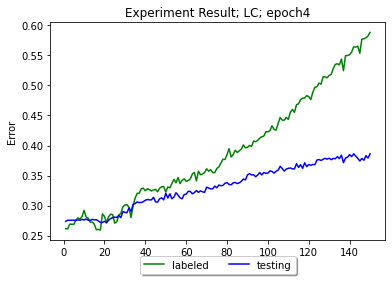

In [4]:
import matplotlib.pyplot as plt

print(expr6._besttestacc)

query_num = range(1,150+1)
plt.plot(query_num, E_out_6['labeled_acc'], 'g', label='labeled')
plt.plot(query_num, E_out_6['testing_acc'], 'b', label='testing')

plt.xlabel('Number of Queries')
plt.ylabel('Error')
plt.title('Experiment Result; LC; epoch4')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=5)
plt.show()

In [5]:
fname = 'mbalf1Biome2.txt'
ofile = open(fname, 'wb')
pickle.dump([E_out_6, 'epoch=4; quota=150'], ofile)
ofile.close()